# Import Libraries

In [ ]:
import pandas as pd
import numpy as np

# from sklearn.neural_network import MLPClassifier  #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# from keras.models import Sequential
# from keras.callbacks import ModelCheckpoint
# from keras.layers import Dense
# from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

# Gathering the data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
len(df)

119390

In [ ]:
df['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [ ]:
df['arrival_date_year'].unique()

array([2015, 2016, 2017])

In [ ]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

# Data Cleaning

### Remove observations where hotel booking was canceled. 

In [ ]:
hotels = df[df['is_canceled'] == 0]
hotels.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
len(hotels)

75166

##### About 2/3 of original data is relevant

### Remove Rows where ADR <= 0

In [ ]:
hotels = hotels[hotels['adr'] > 0]

In [ ]:
len(hotels)

73419

### Drop Unneccessary Columns

In [ ]:
hotels = hotels.drop(['reservation_status_date', 'reservation_status', 'is_canceled'], axis=1)
hotels.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
2,Resort Hotel,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,Resort Hotel,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,Resort Hotel,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1
5,Resort Hotel,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1
6,Resort Hotel,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0


# Feature Engineering

In [ ]:
hotels['percentage_of_booking_canceled'] = hotels['previous_cancellations'] / (hotels['previous_cancellations'] + hotels['previous_bookings_not_canceled'])
# hotels['percentage_of_booking_canceled'] = hotels['percentage_of_booking_canceled'].fillna(0)
hotels.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,percentage_of_booking_canceled
2,Resort Hotel,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,NaN
3,Resort Hotel,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,NaN
4,Resort Hotel,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,NaN
5,Resort Hotel,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,NaN
6,Resort Hotel,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,NaN


In [ ]:
hotels['agent'] = hotels['agent'].astype(str)
hotels['company'] = hotels['company'].astype(str)

# OHE & Separating into 2 different datasets based on type of hotel

In [ ]:
city_hotels = hotels[hotels['hotel'] == 'City Hotel'].drop(columns=['hotel'])
resort_hotels = hotels[hotels['hotel'] == 'Resort Hotel'].drop(columns=['hotel'])

In [ ]:
len(city_hotels) + len(resort_hotels) == len(hotels)

True

In [ ]:
city_hotels.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,percentage_of_booking_canceled
40066,3,2015,July,27,2,0,3,1,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,1.0,nan,0,Transient-Party,58.67,0,0,NaN
40070,43,2015,July,27,3,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,nan,0,Transient-Party,86.00,0,0,NaN
40071,43,2015,July,27,3,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,1.0,nan,0,Transient-Party,43.00,0,0,NaN
40072,43,2015,July,27,3,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,nan,0,Transient-Party,86.00,0,0,NaN
40073,4,2015,July,27,3,0,2,1,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,nan,0,Transient-Party,63.00,0,0,NaN


In [ ]:
resort_hotels.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,percentage_of_booking_canceled
2,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,nan,nan,0,Transient,75.0,0,0,NaN
3,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,nan,0,Transient,75.0,0,0,NaN
4,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,nan,0,Transient,98.0,0,1,NaN
5,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,nan,0,Transient,98.0,0,1,NaN
6,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,nan,nan,0,Transient,107.0,0,0,NaN


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 2.5 MB/s 


In [ ]:
from catboost import CatBoostRegressor

# Train-Test Split

In [ ]:
cat_features = list(city_hotels.dtypes[city_hotels.dtypes == "object"].index)
city_hotels[cat_features] = city_hotels[cat_features].fillna("Null")

Y = city_hotels.adr
X = city_hotels.drop(['adr'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

# Initial Untuned Model - City

In [ ]:
cbr = CatBoostRegressor(cat_features=cat_features,
                        task_type="GPU",
                        devices='0:1',
                        loss_function='MAE',
                        verbose=False)

cbr.fit(X_train, Y_train)

In [ ]:
Y_train_pred = cbr.predict(X_train)
print("Train MAE:", mean_absolute_error(Y_train, Y_train_pred))

print("\n")

Y_test_pred = cbr.predict(X_test)
print("Test MAE:", mean_absolute_error(Y_test, Y_test_pred))


Train MAE: 9.17639739693286


Test MAE: 9.563224765566977


In [ ]:
cbr.feature_importances_

array([9.66511727e+00, 8.55071633e+00, 1.39643351e+01, 5.20272227e+00,
       1.07117420e+00, 3.42339131e-01, 5.18260240e-01, 7.14159975e+00,
       3.40614894e+00, 0.00000000e+00, 5.78960073e+00, 1.16660483e-01,
       2.63315209e+00, 1.45300374e+00, 4.99990024e-02, 1.30827943e-04,
       1.64001815e-01, 1.88702665e+01, 2.47464383e+00, 1.41941285e-02,
       4.18580980e-02, 1.58763243e+01, 1.17761412e+00, 5.76002149e-01,
       3.98297032e-01, 3.93552522e-01, 5.72896990e-02, 5.09958472e-02])

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
print(len(cbr.feature_importances_))

print(len(X_train.columns))

28
28


In [ ]:
top_5_features = pd.DataFrame({'Feature':X_train.columns, 'Feature Importance':cbr.feature_importances_}).sort_values('Feature Importance', ascending=False).iloc[:5, :]
top_5_features

,Feature,Feature Importance
17,reserved_room_type,18.870266
21,agent,15.876324
2,arrival_date_month,13.964335
0,lead_time,9.665117
1,arrival_date_year,8.550716


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


Text(0.5, 1.0, 'Top 5 Features for CatBoost City Hotel Model')

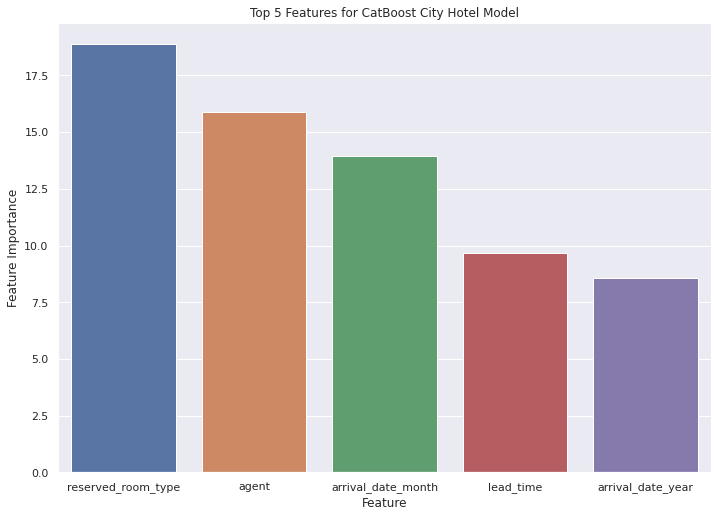

In [ ]:
sns.barplot(x="Feature", y="Feature Importance", data=top_5_features).set_title('Top 5 Features for CatBoost City Hotel Model')

# Initial Untuned Model - Resort

In [ ]:
cat_features = list(resort_hotels.dtypes[resort_hotels.dtypes == "object"].index)
resort_hotels[cat_features] = resort_hotels[cat_features].fillna("Null")

In [ ]:

Y = resort_hotels.adr
X = resort_hotels.drop(['adr'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=40)

In [ ]:
cbr_cv_2 = CatBoostRegressor(cat_features=cat_features,
                           task_type="GPU",
                           devices='0:1',
                           loss_function='MAE',
                           iterations=1000,
                           verbose=False,
                           learning_rate=0.05,
                           depth=10,
                           l2_leaf_reg=7)

cbr_cv_2.fit(X_train, Y_train)

In [ ]:
Y_train_pred = cbr_cv_2.predict(X_train)
print("Train MAE:", mean_absolute_error(Y_train, Y_train_pred))

print("\n")

Y_test_pred = cbr_cv_2.predict(X_test)
print("Test MAE:", mean_absolute_error(Y_test, Y_test_pred))

Train MAE: 6.517008334533774


Test MAE: 7.954537953270244


In [ ]:
top_5_features_2 = pd.DataFrame({'Feature':X_train.columns, 'Feature Importance':cbr_cv_2.feature_importances_}).sort_values('Feature Importance', ascending=False).iloc[:5, :]
top_5_features_2

,Feature,Feature Importance
2,arrival_date_month,25.849007
17,reserved_room_type,9.080660
1,arrival_date_year,9.014327
10,meal,8.574690
0,lead_time,8.281046


Text(0.5, 1.0, 'Top 5 Features for CatBoost Resort Hotel Model')

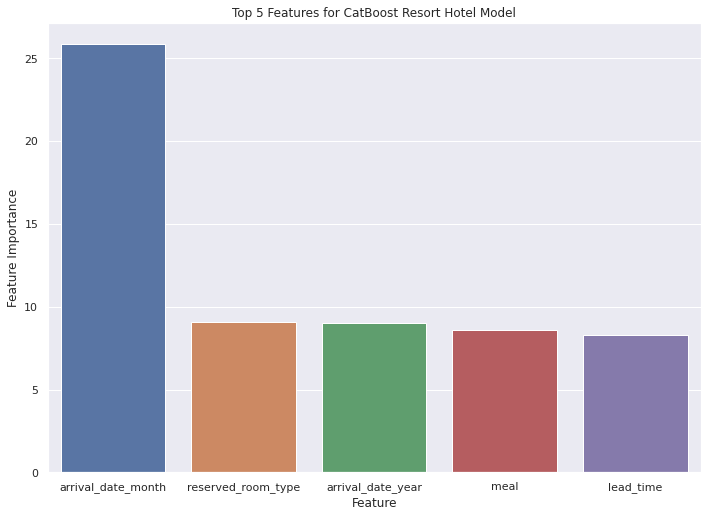

In [ ]:
sns.barplot(x="Feature", y="Feature Importance", data=top_5_features_2).set_title('Top 5 Features for CatBoost Resort Hotel Model')